# Fine-tuning to follow instructions

Instruction fine-tuning is one of the main techniques behind developing LLMs for chatbot apps, personal assistants, and other conversational

Herer, we focus on improving the LLM's ability to follow instructions and generate desired response. Preparing the dataset is a key aspect of instruction fine-tuning

The dataset consists of 1,100 instruction-response pairs 

In [1]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)
data = download_and_load_file(file_path, url)
print("Number of entries", len(data))
    

Number of entries 1100


In [2]:
print("example entry:\n", data[50])

example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [3]:
print("example entry:\n", data[999])


example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


There are various methods to format the entries for LLMs. The following figure illustrates 2 different example formats, often referred to as **prompt styles** used in training of notable LLMs such as Alpaca and Phi-3

![prompt_style](prompt_style.png)

In [4]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )
    return instruction_text + input_text

In [5]:
model_input = format_input(data[50])
desired_response = f'\n\n### Response:\n{data[50]["output"]}'
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [6]:
model_input = format_input(data[999])
desired_response = f'\n\n### Response:\n{data[50]["output"]}'
print(model_input + desired_response)


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
The correct spelling is 'Occasion.'


In [7]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Testing set length:", len(test_data))

Training set length: 935
Validation set length: 55
Testing set length: 110


# Organizing data into training batches

we learn how to efficiently pad the data samples to equal lengths so we can assemble multiple instruction examples in a batch
In the previous chapter, the training batches were created automatically by the PyTorch `DataLoader` class, which employes the default collate function to combine lists of samples into batches.
A collate function is responsible for taking a list of individual data samples and merging hem into a single batch that can be processed efficiently by the model during training
However the batching process for instruction fine-tuning is a bit more involved and requires us to create our own custom colloate function that will later plug into the `DataLoader` 

![batching process instruction dataset](batching_process.png)



In [8]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_text = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_text.append(
                tokenizer.encode(full_text)
            )
    
    def __getitem__(self, index):
        return self.encoded_text[index]
    
    def __len__(self):
        return len(self.data)
    

In [9]:
# For padding we can append the token ID corresponding to `<|endoftext|>` to the pretokenized inputs directly.

import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [10]:
# custom collate fucntion that we can pass to the dataloader. It pads the training examples in each batch to the same length while allowing different batches to have different lenghts. This approach minimizes unnecessary padding by only extending sequences to match the longest one in each batch, not the whole dataset

def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    input_lst = []
    
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # removes extra padded token added earlier
        input_lst.append(inputs)
    
    inputs_tensor = torch.stack(input_lst).to(device)
    return inputs_tensor

In [11]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [12]:
# we modify our custom collate function to return the tarket token IDs in addition to the input token IDs.
# Similar to the processs we used to pretrain an LLM, the target token IDs match the input token IDs but are shifted one position to the right.
# It allows the LLM o learn how to predict the next token in a sequence

def custom_collate_draft2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []
    
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  
        targets = torch.tensor(inputs[1:])
        
        inputs_lst.append(inputs)
        targets_lst.append(targets)
        
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    
    return inputs_tensor, targets_tensor

inputs, targets = custom_collate_draft2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4],
        [    6, 50256, 50256, 50256],
        [    8,     9, 50256, 50256]])


/var/folders/8n/tlk756jx44lbb6m66gsbw03m0000gn/T/ipykernel_41892/81555748.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(inputs[1:])


In the next step, we assign a `-100` placeholder value to all padding tokens. This special value allows us to exclude thes padding tokens from contributing to the training loss calculation, ensuring that only meaningful data influences model learning.
When fine tuning for classification, we did not have to worry about this since we only trained the model based on the last output token
However, we retain one end-of-text token, in the target list. Retaining it allows the LLM to learn when to generate an end-of-text token in response to instructions, which we use as an indicator that the generated response is complete.


The defaualt setting of the cross entropy function in PyTorch is `cross_entropy(...,ignore_index=-100)`. This means that it ignores targets labeled with `-100`. We take advantage of this `ignore_index` to ignore the additional EOF (padding) tokens that we used to pad the training examples to have the same length in each batch.


In [23]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,   # parameter to optionally limit the length of samples
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []
    
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  
        targets = torch.tensor(padded[1:])
        
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
            
        inputs_lst.append(inputs)
        targets_lst.append(targets)
        
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    
    return inputs_tensor, targets_tensor

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In addition to masking out padding tokens, it is also common to mask out the target token IDs that correspond to the instruction. By doing so, the cross entropy loss is only computed for the generated response target IDs. Thus the model is trained to focus on generating accurate responses rather that memorizing  instructions, which can help reduce overfitting

# Creating data loaders for an instruction dataset

Previously we moved the data onto the target device in the main training loop
Having this as part of the collate function offers the advantage of performing this devie transfer process as a background porcess outside the training loop, preventing it from blocking the GPU during model training

In [14]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
if torch.backends.mps.is_available():
    device = torch.device("mps")
device = "cpu"
print("Device:", device)

Device: cpu


In [24]:
# To reuse the chosen device setting in `custom_collate_fn` when we plug it into the PyTorch `DataLoader` class, we use the `partial` function from Python's `functools` standard library to create a new version of the function with the device arg prefilled
# additionally, we set the `allowed_max_length` to 1024 which truncates the data too the maximum context length supported by GPT-2 model

from functools import partial
custom_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
) 

In [25]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)


test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [26]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

# Loading a pretrained LLM

We load the medium-sized model with 355 million parameters. The reason for this choice is that the 124-million parameter model is too limited in capacity to achieve statisfactory results. 
Specificall, smaller models lack the necessary capacity to learn and retain the intricated patters and nuanced behaviors required for high quality instruction following tasks

In [18]:
from gpt_download import download_and_load_gpt2
from chapter_04 import GPTModel
from chapter_05 import load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size, 
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 10.6kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 808kiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 29.0kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [05:29<00:00, 4.30MiB/s] 
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 6.37MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 810kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 571kiB/s] 


In [21]:
from chapter_05 import generate, text_to_token_ids, token_ids_to_text


torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)
response_text = generated_text[len(input_text):].strip()
print(response_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'
### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


# Fine-tuning the LLM on instruction data

In [27]:
from chapter_05 import (
    calc_loss_loader,
    train_model_simple
)

model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.825894069671631
Validation loss: 3.7619182586669924


In [28]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2

train_losses, val_losses, token_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=5,
    eval_iter=5, start_context=format_input(val_data[0]), tokenizer=tokenizer
)
end_time = time.time()
execution_time = (end_time - start_time) /60
print(f"Training completed in {execution_time:.2f} minutes")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.945
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.790
Ep 1 (Step 000050): Train loss 0.662, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.764
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.652, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.562, Val loss

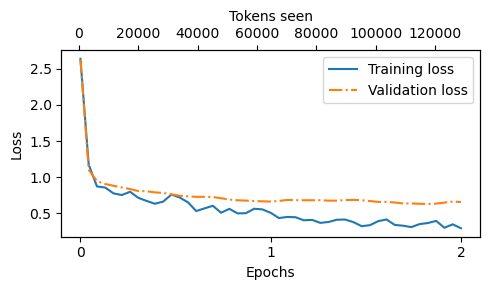

In [29]:
from chapter_05 import plot_losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, token_seen, train_losses, val_losses)

In [30]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("----------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
----------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
----------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride a

Instruction -fine-tuned LLMs such as chatbots are evaluated via multiple approaches:
- Short-answer and multiple-choice benchmarks, such as Measuring Massive Multitask Language Understanding (MMLU) which test the general knowledge of a model
- Human preference comparison to other LLMs such as LMSYS chatbot arean
- Automated conversational benchmarks, where another LLM like GPT-4 is used to evaluate the responses, such as AlpacaEval

## Conversational performance

It refers to the ability of LLMs to engage in human-like communication by understanding context, nuance, and intent. It encompasses skills such as providing relevant and coherent responses, maintaining consistency, and adapting to different topics and styles of interaction


To evaluate test set responses in an automated fashion, we utilize an exisiting instruction-fine-tuned 8-billion parameter Llama 3 model. This model can be run locally using the open source Ollama application
**Ollama** is an efficient application for running LLMs on a laptop. It serves as a wrapper around the open source llama.cpp library which implements LLMs in pure C/C++ to maximize efficiency. 
However, Ollama is only a tool for generating text using LLMs (infernce) and does not support training or fine-tuning LLMs.

The `llama3` in the `ollama run llama3` command refers to the instruction-fine-tuned 8-billion parameter Llama 3 model. Using Ollama with the llama3 model requires approxiamtely 16GB of RAM. You can try using a smaller model, such as the 3.8 billion parameter `phi3` model via `ollama run llama3` which only requires around 8GB of RAM

For more powerful computers, you can also use the larger 70-billion parameter Llama3 model by replacing llama3 with `llana3:70b` 


In [31]:
# Verify that the Ollama session is running

import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError(
        "Ollama not running. Launch ollama before proceeding."
)
print("Ollama running:", check_if_running("ollama"))

RuntimeError: Ollama not running. Launch ollama before proceeding.

In [ ]:
# alternative to the ollama run command for interacting with the model is through itsREST API using Pythoh 

import urllib.request

def query_model(  # shows how to use the API
    prompt, 
    model="llama3", 
    url="http://localhost:11434/api/chat"
):
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )

    request.add_header("Content-Type", "application/json")

    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data

In [ ]:
import tqdm
import json

def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

There is an optional step that can be performed after instruction fine tuning: preference fine tuning. It is particularly useful for customizing a model to better align with specific user preferences,


Parameter efficient fine tuning with LoRA (low-rank adaptation method)